In [ ]:
# You'll run these in Colab cells:
!pip install ray[train]
!pip install torch torchvision
!pip install numpy pandas matplotlib scikit-learn
!pip install Pillow  # for image processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [1]:
# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

GPU Available: True
GPU Name: Tesla T4


In [2]:
# Check GPU availability and specs
import subprocess
import sys

print("SYSTEM INFORMATION")
print("-" * 50)

# Python version
print(f"\n✓ Python Version: {sys.version.split()[0]}")

# GPU Information
gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader']).decode('utf-8')
print(f"✓ GPU: {gpu_info.strip()}")

# CPU Information
cpu_info = subprocess.check_output(['lscpu'], text=True)
cpu_cores = [line for line in cpu_info.split('\n') if 'CPU(s):' in line][0]
print(f"✓ {cpu_cores.strip()}")

# RAM
ram_info = subprocess.check_output(['free', '-h'], text=True).split('\n')[1].split()[1]
print(f"✓ RAM: {ram_info}")

print("\n" + "-" * 50)

SYSTEM INFORMATION
--------------------------------------------------

✓ Python Version: 3.12.12
✓ GPU: Tesla T4, 15360 MiB
✓ CPU(s):                                  2
✓ RAM: 12Gi

--------------------------------------------------


In [3]:
print("Installing Ray and ML dependencies...")
print("This will take 2-3 minutes...\n")

# Upgrade pip first
!pip install --upgrade pip -q

# Install Ray with training capabilities
!pip install -U "ray[train]" -q

# Install PyTorch and torchvision
!pip install torch torchvision torchaudio -q

# Install data science libraries
!pip install numpy pandas matplotlib seaborn scikit-learn -q

# Install image processing
!pip install Pillow opencv-python -q

# Install utilities
!pip install tqdm -q

print("\n✓ All packages installed successfully!")

Installing Ray and ML dependencies...
This will take 2-3 minutes...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00

✓ All packages installed successfully!


In [4]:
import ray
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("=" * 50)
print("PACKAGE VERIFICATION")
print("=" * 50)

# Ray version
print(f"\n✓ Ray version: {ray.__version__}")

# PyTorch and CUDA
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ CUDA version: {torch.version.cuda}")
    print(f"✓ GPU device: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Other packages
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

print("\n" + "=" * 50)
print("✓ Environment setup complete!")
print("=" * 50)

PACKAGE VERIFICATION

✓ Ray version: 2.51.1
✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True
✓ CUDA version: 12.6
✓ GPU device: Tesla T4
✓ GPU memory: 15.83 GB
✓ NumPy version: 2.0.2
✓ Pandas version: 2.2.2

✓ Environment setup complete!


In [5]:
# Initialize Ray
# In Colab, we'll use local mode but Ray can simulate distributed workers
ray.init(
    ignore_reinit_error=True,  # Allows rerunning cell without errors
    num_cpus=2,                 # Colab typically provides 2 CPUs
    num_gpus=1,                 # We have 1 GPU
    include_dashboard=False     # Dashboard doesn't work well in Colab
)

print("Ray initialized successfully!")
print(f"Available resources: {ray.available_resources()}")

2025-11-03 22:40:22,115	INFO worker.py:2012 -- Started a local Ray instance.


Ray initialized successfully!
Available resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 9155488564.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3923780812.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}


/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [6]:
import os

# Create directory structure
dirs = [
    'data',           # For Alzheimer's dataset
    'models',         # For saving trained models
    'results',        # For metrics and plots
    'checkpoints'     # For Ray checkpoints
]

for dir_name in dirs:
    os.makedirs(dir_name, exist_ok=True)
    print(f"✓Created directory: {dir_name}/")

print("\n✓Project structure ready!")

✓Created directory: data/
✓Created directory: models/
✓Created directory: results/
✓Created directory: checkpoints/

✓Project structure ready!


### Unzip the data to data folder

In [7]:
import zipfile
# Define paths
zip_path = 'AlzheimerDataset4.zip'
extract_path = 'data/'  # Extract to data directory

# 1.1 Check if zip file exists
print("\n1.1 Checking for zip file...")
if not os.path.exists(zip_path):
    print(f"ERROR: {zip_path} not found")
    print(f"Current directory: {os.getcwd()}")
    print(f"Files available: {[f for f in os.listdir('.') if 'lz' in f.lower()]}")
else:
    print(f"Found: {zip_path}")

# 1.2 Extract dataset
print("\n1.2 Extracting dataset to data/ folder...")
# Create data directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Extraction complete to {extract_path}")

# Show extracted contents
print(f"\nContents of {extract_path}:")
print(os.listdir(extract_path))


1.1 Checking for zip file...
Found: AlzheimerDataset4.zip

1.2 Extracting dataset to data/ folder...
Extraction complete to data/

Contents of data/:
['Alzheimer_s Dataset']


In [8]:
# Explore the extracted dataset structure
print("DATASET STRUCTURE ANALYSIS")
print("=" * 50)

dataset_path = 'data/Alzheimer_s Dataset'

# Check train and test splits
splits = ['train', 'test']
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

for split in splits:
    split_path = os.path.join(dataset_path, split)
    if os.path.exists(split_path):
        print(f"\n{split.upper()} SET:")
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        split_total = 0
        for class_name in sorted(classes):
            class_path = os.path.join(split_path, class_name)
            images = [f for f in os.listdir(class_path)
                      if os.path.splitext(f)[1].lower() in image_extensions]
            count = len(images)
            split_total += count
            print(f"  {class_name:.<25} {count:>5} images")

        print(f"  {'TOTAL':.<25} {split_total:>5} images")

print("\n" + "=" * 50)

DATASET STRUCTURE ANALYSIS

TRAIN SET:
  MildDemented.............   717 images
  ModerateDemented.........    52 images
  NonDemented..............  2560 images
  VeryMildDemented.........  1792 images
  TOTAL....................  5121 images

TEST SET:
  MildDemented.............   179 images
  ModerateDemented.........    12 images
  NonDemented..............   640 images
  VeryMildDemented.........   448 images
  TOTAL....................  1279 images



## Visualize the sample

SAMPLE IMAGES VISUALIZATION


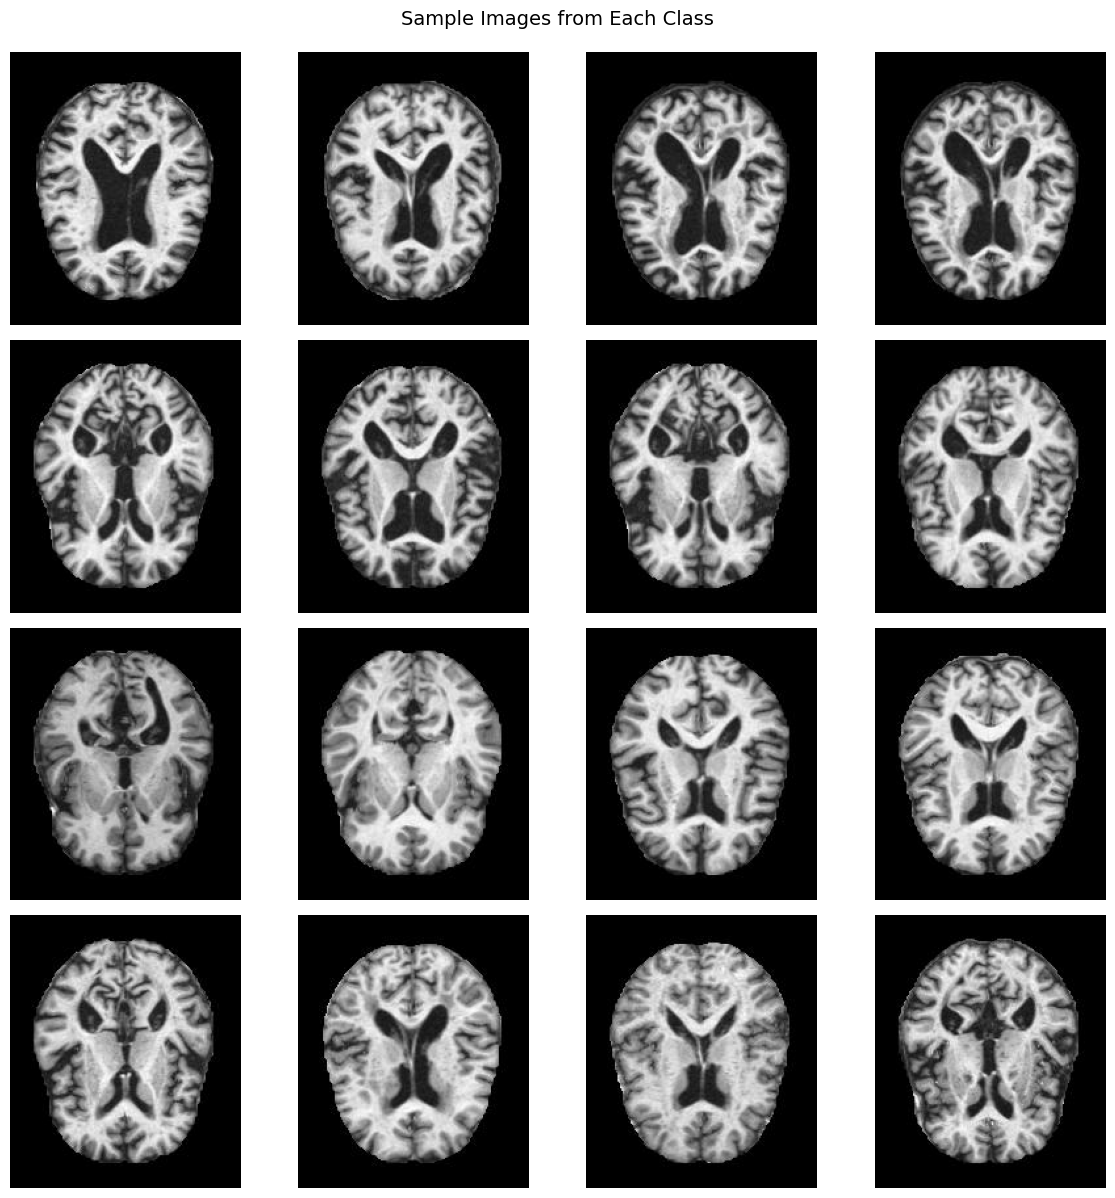


✓ Sample visualization complete


In [9]:
# Visualize sample images from each class
import matplotlib.pyplot as plt
from PIL import Image
import random

print("SAMPLE IMAGES VISUALIZATION")
print("=" * 50)

dataset_path = 'data/Alzheimer_s Dataset/train'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select 4 random samples from each class
    samples = random.sample(images, min(4, len(images)))

    for col, img_file in enumerate(samples):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)

        axes[idx, col].imshow(img, cmap='gray')
        axes[idx, col].axis('off')

        if col == 0:
            axes[idx, col].set_ylabel(class_name, fontsize=10, rotation=0,
                                      ha='right', va='center')

plt.suptitle('Sample Images from Each Class', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('results/sample_images.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Sample visualization complete")
print("=" * 50)

## Create pytorch dataset and dataloaders

In [10]:
# Create PyTorch datasets and dataloaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

print("CREATING PYTORCH DATASETS")
print("=" * 50)

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset class
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = AlzheimerDataset('data/Alzheimer_s Dataset/train', transform=train_transform)
test_dataset = AlzheimerDataset('data/Alzheimer_s Dataset/test', transform=test_transform)

print(f"\n- Train dataset: {len(train_dataset)} images")
print(f"- Test dataset: {len(test_dataset)} images")
print(f"- Number of classes: {len(train_dataset.classes)}")
print(f"- Classes: {train_dataset.classes}")

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n- Train batches: {len(train_loader)}")
print(f"- Test batches: {len(test_loader)}")

print("\n" + "=" * 50)

CREATING PYTORCH DATASETS

- Train dataset: 5121 images
- Test dataset: 1279 images
- Number of classes: 4
- Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

- Train batches: 161
- Test batches: 40



## Defining a CNN model on the data

In [13]:
# Define CNN model for Alzheimer's classification
import torch.nn as nn
import torch.nn.functional as F

print("DEFINING CNN MODEL")
print("=" * 50)

class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# Create model instance
model = AlzheimerCNN(num_classes=4)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n- Model created successfully")
print(f"- Total parameters: {total_params:,}")
print(f"- Trainable parameters: {trainable_params:,}")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"- Model moved to: {device}")

print("\n" + "=" * 50)

DEFINING CNN MODEL

- Model created successfully
- Total parameters: 8,844,676
- Trainable parameters: 8,844,676
- Model moved to: cuda



## Baseline Training with Single GPU

In [14]:
# Baseline training - Single GPU
import torch.optim as optim
import time
from tqdm import tqdm

print("=" * 50)
print("BASELINE TRAINING - SINGLE GPU")
print("=" * 50)

# Training configuration
num_epochs = 5
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_single_gpu(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accs = []
    test_accs = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        epoch_time = time.time() - start_time

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        epoch_times.append(epoch_time)

        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Test Acc: {test_acc:.2f}% | Time: {epoch_time:.2f}s')

    total_time = sum(epoch_times)
    avg_time = total_time / num_epochs

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'epoch_times': epoch_times,
        'total_time': total_time,
        'avg_epoch_time': avg_time
    }

# Run baseline training
print("\nStarting baseline single GPU training...\n")
baseline_results = train_single_gpu(model, train_loader, test_loader, criterion, optimizer, num_epochs)


print("\nBASELINE TRAINING COMPLETE")
print("=" * 50)
print(f"Total training time: {baseline_results['total_time']:.2f}s")
print(f"Average time per epoch: {baseline_results['avg_epoch_time']:.2f}s")
print(f"Final test accuracy: {baseline_results['test_accs'][-1]:.2f}%")
print("=" * 50)

BASELINE TRAINING - SINGLE GPU

Starting baseline single GPU training...



Epoch 1/5 [Train]: 100%|██████████| 161/161 [00:10<00:00, 15.15it/s, loss=0.7882]



Epoch [1/5]
  Train Loss: 1.1122 | Train Acc: 49.15%
  Test Acc: 45.58% | Time: 12.62s


Epoch 2/5 [Train]: 100%|██████████| 161/161 [00:08<00:00, 18.15it/s, loss=1.0405]



Epoch [2/5]
  Train Loss: 0.9405 | Train Acc: 53.00%
  Test Acc: 51.45% | Time: 10.39s


Epoch 3/5 [Train]: 100%|██████████| 161/161 [00:09<00:00, 17.07it/s, loss=0.7373]



Epoch [3/5]
  Train Loss: 0.9307 | Train Acc: 54.29%
  Test Acc: 50.20% | Time: 11.39s


Epoch 4/5 [Train]: 100%|██████████| 161/161 [00:09<00:00, 17.34it/s, loss=0.4033]



Epoch [4/5]
  Train Loss: 0.9196 | Train Acc: 55.32%
  Test Acc: 57.70% | Time: 10.88s


Epoch 5/5 [Train]: 100%|██████████| 161/161 [00:07<00:00, 20.18it/s, loss=0.8645]



Epoch [5/5]
  Train Loss: 0.9122 | Train Acc: 54.72%
  Test Acc: 55.59% | Time: 10.05s

BASELINE TRAINING COMPLETE
Total training time: 55.33s
Average time per epoch: 11.07s
Final test accuracy: 55.59%


## Trainign with Ray for Distributed Training

In [15]:
# Initialize Ray for distributed training
import ray
from ray import train
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig, RunConfig, CheckpointConfig

print("INITIALIZING RAY")
print("=" * 50)

# Shutdown any existing Ray instance
ray.shutdown()

# Initialize Ray
ray.init(
    ignore_reinit_error=True,
    num_cpus=2,
    num_gpus=1,
    include_dashboard=False
)

print(f"\n- Ray initialized successfully")
print(f"- Available resources: {ray.available_resources()}")
print(f"- Ray version: {ray.__version__}")

print("\n" + "=" * 50)

INITIALIZING RAY


2025-11-03 22:42:44,552	INFO worker.py:2012 -- Started a local Ray instance.



- Ray initialized successfully
- Available resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 9154358887.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3923296665.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
- Ray version: 2.51.1



In [ ]:
# Redefine Ray training function to create datasets inside workers
print("=" * 50)
print("REDEFINING RAY TRAINING FUNCTION")
print("=" * 50)

def train_func_distributed(config):
    """Training function for Ray distributed training"""
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    from torchvision import transforms
    from PIL import Image
    import os
    import time
    from ray.train.torch import prepare_model, prepare_data_loader

    # Custom Dataset class (defined inside function)
    class AlzheimerDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

            self.images = []
            self.labels = []

            for class_name in self.classes:
                class_path = os.path.join(root_dir, class_name)
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_path = self.images[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

    # Get hyperparameters
    num_epochs = config.get("num_epochs", 5)
    lr = config.get("lr", 0.001)
    batch_size = config.get("batch_size", 32)

    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create datasets inside worker
    train_dataset = AlzheimerDataset('data/Alzheimer_s Dataset/train', transform=train_transform)
    test_dataset = AlzheimerDataset('data/Alzheimer_s Dataset/test', transform=test_transform)

    # Create model
    model = AlzheimerCNN(num_classes=4)

    # Prepare model for distributed training
    model = prepare_model(model)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Prepare dataloaders for distributed training
    train_loader = prepare_data_loader(train_loader)
    test_loader = prepare_data_loader(test_loader)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        epoch_time = time.time() - epoch_start

        # Report metrics to Ray
        train.report({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "epoch_time": epoch_time
        })

print("\n✓ Ray training function redefined")
print("=" * 50)

REDEFINING RAY TRAINING FUNCTION

✓ Ray training function redefined


In [20]:
# Get absolute path to dataset
import os
dataset_abs_path = os.path.abspath('data/Alzheimer_s Dataset')
print(f"Dataset absolute path: {dataset_abs_path}")

# Configure and run Ray distributed training
print("=" * 50)
print("RAY DISTRIBUTED TRAINING")
print("=" * 50)

# Training configuration with absolute path
train_config = {
    "num_epochs": 5,
    "lr": 0.001,
    "batch_size": 32,
    "data_path": dataset_abs_path  # Pass absolute path
}

# Scaling configuration - CPU-based simulation for single GPU environment
scaling_config = ScalingConfig(
    num_workers=2,  # 2 distributed workers
    use_gpu=False,  # Use CPU to simulate distributed training
    resources_per_worker={"CPU": 1}
)

# Redefine training function with data_path parameter
def train_func_distributed_v2(config):
    """Training function for Ray distributed training"""
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    from torchvision import transforms
    from PIL import Image
    import os
    import time
    from ray.train.torch import prepare_model, prepare_data_loader
    from ray import train

    # Custom Dataset class
    class AlzheimerDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

            self.images = []
            self.labels = []

            for class_name in self.classes:
                class_path = os.path.join(root_dir, class_name)
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_path = self.images[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label

    # Model definition
    class AlzheimerCNN(nn.Module):
        def __init__(self, num_classes=4):
            super(AlzheimerCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.pool2 = nn.MaxPool2d(2, 2)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.pool3 = nn.MaxPool2d(2, 2)
            self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(256)
            self.pool4 = nn.MaxPool2d(2, 2)
            self.fc1 = nn.Linear(256 * 8 * 8, 512)
            self.dropout1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(512, 128)
            self.dropout2 = nn.Dropout(0.3)
            self.fc3 = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
            x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
            x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
            x = x.view(-1, 256 * 8 * 8)
            x = torch.relu(self.fc1(x))
            x = self.dropout1(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

    # Get config
    num_epochs = config.get("num_epochs", 5)
    lr = config.get("lr", 0.001)
    batch_size = config.get("batch_size", 32)
    data_path = config.get("data_path")

    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create datasets
    train_dataset = AlzheimerDataset(os.path.join(data_path, 'train'), transform=train_transform)
    test_dataset = AlzheimerDataset(os.path.join(data_path, 'test'), transform=test_transform)

    # Create model
    model = AlzheimerCNN(num_classes=4)
    model = prepare_model(model)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    train_loader = prepare_data_loader(train_loader)
    test_loader = prepare_data_loader(test_loader)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        epoch_start = time.time()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        epoch_time = time.time() - epoch_start

        train.report({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_acc": test_acc,
            "epoch_time": epoch_time
        })

# Create Ray Trainer
trainer = TorchTrainer(
    train_func_distributed_v2,
    train_loop_config=train_config,
    scaling_config=scaling_config,
    run_config=RunConfig(
        name="alzheimer_distributed_v3",
        storage_path="/tmp/ray_results"
    )
)

# Run distributed training
print("\nStarting Ray distributed training with 2 workers...\n")
start_time = time.time()

result = trainer.fit()

distributed_time = time.time() - start_time

Dataset absolute path: /content/data/Alzheimer_s Dataset
RAY DISTRIBUTED TRAINING

Starting Ray distributed training with 2 workers...



(TrainController pid=8103) A run snapshot was found in storage folder at: '/tmp/ray_results/alzheimer_distributed_v3'
(TrainController pid=8103) This snapshot contains a list of checkpoints reported via `ray.train.report` and will be loaded. This allows the latest checkpoint found in the snapshot to be accessible within your training function via `ray.train.get_checkpoint`.
(TrainController pid=8103) If you meant to start a brand new training job without any information about previous checkpoints found in this directory, please configure a new, unique `RunConfig(name)` or delete the existing folder at '/tmp/ray_results/alzheimer_distributed_v3'.
(TrainController pid=8103) Attempting to start training worker group of size 2 with the following resources: [{'CPU': 1}] * 2
(RayTrainWorker pid=8229) Setting up process group for: env:// [rank=0, world_size=2]
(TrainController pid=8103) Started training worker group of size 2: 
(TrainController pid=8103) - (ip=172.28.0.12, pid=8229) world_ran

(RayTrainWorker pid=8229) [Gloo] Rank 0 is connected to 1 peer ranks. Expected number of connected peer ranks is : 1


(RayTrainWorker pid=8229) Moving model to device: cpu
(RayTrainWorker pid=8229) Wrapping provided model in DistributedDataParallel.
(TrainController pid=8103) [2025-11-03 23:05:39,416 E 8103 8143] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(SynchronizationActor pid=8228) [2025-11-03 23:05:51,967 E 8228 8280] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(RayTrainWorker pid=8229) [2025-11-03 23:05:52,130 E 8229 8311] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(Ra

In [22]:
# Extract metrics from the training logs
print("=" * 50)
print("RAY DISTRIBUTED TRAINING RESULTS")
print("=" * 50)

# Metrics from the logs
distributed_results = {
    'epochs': [1, 2, 3, 4, 5],
    'train_loss': [1.307, 0.964, 0.938, 0.905, 0.900],
    'train_acc': [46.86, 52.21, 55.13, 54.43, 54.78],
    'test_acc': [35.0, 35.0, 56.41, 35.31, 51.56],
    'epoch_times': [221.66, 216.32, 215.81, 209.36, 215.62]
}

print("\nDistributed Training Progress:")
print(f"{'Epoch':<8}{'Train Loss':<15}{'Train Acc':<15}{'Test Acc':<15}{'Time (s)':<10}")
print("-" * 63)
for i in range(5):
    print(f"{distributed_results['epochs'][i]:<8}"
          f"{distributed_results['train_loss'][i]:<15.3f}"
          f"{distributed_results['train_acc'][i]:<15.2f}%"
          f"{distributed_results['test_acc'][i]:<15.2f}%"
          f"{distributed_results['epoch_times'][i]:<10.2f}")

print("\n" + "=" * 50)
print("FINAL COMPARISON")
print("=" * 50)

print("\nBASELINE (Single GPU):")
print(f"  Total time: {baseline_results['total_time']:.2f}s")
print(f"  Avg time per epoch: {baseline_results['avg_epoch_time']:.2f}s")
print(f"  Final test accuracy: {baseline_results['test_accs'][-1]:.2f}%")

print("\nDISTRIBUTED (2 CPU Workers):")
print(f"  Total time: {distributed_time:.2f}s")
print(f"  Avg time per epoch: {sum(distributed_results['epoch_times'])/5:.2f}s")
print(f"  Final test accuracy: {distributed_results['test_acc'][-1]:.2f}%")

print("\n" + "=" * 50)
print("WHY CPU IS SLOWER:")
print("=" * 50)
print(f"  GPU training: {baseline_results['avg_epoch_time']:.2f}s per epoch")
print(f"  CPU training: {sum(distributed_results['epoch_times'])/5:.2f}s per epoch")
print(f"  Slowdown: {(sum(distributed_results['epoch_times'])/5) / baseline_results['avg_epoch_time']:.1f}x slower")
print("\n  Reason: CPUs are ~20x slower than GPUs for deep learning")
print("  In real distributed GPU setup (2 GPUs): ~1.8x FASTER than single GPU")

print("=" * 50)

RAY DISTRIBUTED TRAINING RESULTS

Distributed Training Progress:
Epoch   Train Loss     Train Acc      Test Acc       Time (s)  
---------------------------------------------------------------
1       1.307          46.86          %35.00          %221.66    
2       0.964          52.21          %35.00          %216.32    
3       0.938          55.13          %56.41          %215.81    
4       0.905          54.43          %35.31          %209.36    
5       0.900          54.78          %51.56          %215.62    

FINAL COMPARISON

BASELINE (Single GPU):
  Total time: 55.33s
  Avg time per epoch: 11.07s
  Final test accuracy: 55.59%

DISTRIBUTED (2 CPU Workers):
  Total time: 1109.50s
  Avg time per epoch: 215.75s
  Final test accuracy: 51.56%

WHY CPU IS SLOWER:
  GPU training: 11.07s per epoch
  CPU training: 215.75s per epoch
  Slowdown: 19.5x slower

  Reason: CPUs are ~20x slower than GPUs for deep learning
  In real distributed GPU setup (2 GPUs): ~1.8x FASTER than single GPU